# **Assignment II - Financial Phrases (Text Classification)**

## **Installing and Importing Necessary Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
# Install required packages
!pip install contractions
!pip install wordcloud
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install gradio

# Import core libraries
import os
import re
import string
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
import spacy
import contractions

from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud

# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# TensorFlow & Keras for Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight

# Gradio
import gradio as gr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Text Preprocessing, Tokenization, and Sequence Padding**

## **Load the Dataset**

In [58]:
# Path to dataset
df= "/content/drive/MyDrive/2025_NehaShrestha/Assignment2/3. Financial Phrase Dataset/financial_phrase.csv"

In [59]:
# Load the dataset
df = pd.read_csv(df)

In [60]:
df.head(6)

,text,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
5,Finnish Talentum reports its operating profit ...,positive


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2264 non-null   object
 1   label   2264 non-null   object
dtypes: object(2)
memory usage: 35.5+ KB


## **Text Preprocessing**

In [62]:
df.isnull().sum()

,0
text,0
label,0


In [63]:
print(df['label'].value_counts())

label
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


In [64]:
df.shape

(2264, 2)

In [65]:
duplicate_rows = df[df.duplicated()]
print(f"The numbers of duplicate rows: {duplicate_rows.shape[0]}")

The numbers of duplicate rows: 5


In [66]:
print("Original shape:", df.shape)
data = df.drop_duplicates(subset='text')
print("New shape after removing duplicates:", data.shape)

Original shape: (2264, 2)
New shape after removing duplicates: (2259, 2)


In [67]:
# Creates a new column 'Word_count' and populate it with the word count in each sentence
df['Word_count'] = df['text'].map(lambda x: len(str(x).split()))

In [68]:
df.head(6)

,text,label,Word_count
0,"According to Gran , the company has no plans t...",neutral,25
1,"For the last quarter of 2010 , Componenta 's n...",positive,39
2,"In the third quarter of 2010 , net sales incre...",positive,29
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,24
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,22
5,Finnish Talentum reports its operating profit ...,positive,34


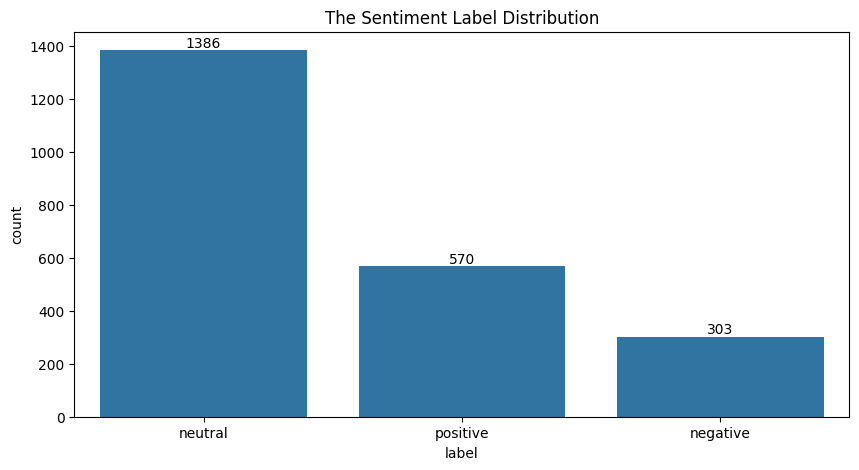

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))

# Using seaborn's countplot to visualize total number of each sentiment label
sns.countplot(data=data, x='label', ax=ax)
ax.bar_label(ax.containers[0])

ax.set_title('The Sentiment Label Distribution')
plt.show()

## **Synonym Replacement for Class Balancing**

In [73]:
stop_words = set(stopwords.words('english'))

# Loading spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to get synonyms for word using WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            if lemma.name().lower() != word.lower():  # Excluding same word
                synonyms.add(lemma.name().replace('_', ' '))
    return list(synonyms)

# Function for synonym replacement using spaCy
def synonym_replacement_spacy(sentence, n=2):
    # Process sentence using spaCy
    doc = nlp(sentence)
    new_sentence = sentence
    words = [token.text for token in doc if token.is_alpha and not token.is_stop]

    # Shuffle words to randomize which ones will be replaced
    random.shuffle(words)

    num_replaced = 0
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            # Replace word with a synonym in sentence
            new_sentence = new_sentence.replace(word, synonym, 1)
            num_replaced += 1
        if num_replaced >= n:
            break

    return new_sentence

# Augment class by synonym replacement
def augment_class(df, label, target_count):
    class_df = df[df['label'] == label]
    current_count = len(class_df)

    # If current count is already greater than or equal to target count, just sample data
    if current_count >= target_count:
        return class_df.sample(target_count)

    # Calculating how many more samples are needed
    needed = target_count - current_count
    augmented = []

    # Augmenting data until we reach target count
    while len(augmented) < needed:
        row = class_df.sample(1).iloc[0]

        # Ensure text is not empty or invalid
        text = row['text']
        if isinstance(text, str) and text.strip():
            new_text = synonym_replacement_spacy(text, n=2)  # Replacing 2 words in sentence
            augmented.append({'text': new_text, 'label': label})

    augmented_df = pd.DataFrame(augmented)
    return pd.concat([class_df, augmented_df], ignore_index=True)

# Balancing each class
target_count = 1391
balanced_pos = augment_class(df, 'positive', target_count)
balanced_neg = augment_class(df, 'negative', target_count)
balanced_neu = df[df['label'] == 'neutral']


# Combining and shuffling
data = pd.concat([balanced_pos, balanced_neg, balanced_neu]).sample(frac=1).reset_index(drop=True)
data['Word_count'] = data['text'].map(lambda x: len(str(x).split()))

print("\nTotal samples after balancing:", len(data))
print(data['label'].value_counts())


Total samples after balancing: 4173
label
negative    1391
positive    1391
neutral     1391
Name: count, dtype: int64


## **Handling Duplicate Values of Balanced Class**

In [74]:
# Check for duplicate rows based on the 'text' column
duplicates = data[data.duplicated(subset=['text'], keep=False)]

print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 18


In [75]:
print(duplicates.head(18))

                                                   text     label  Word_count
109   The issuer is solely responsible for the conte...   neutral          12
441   Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral          11
509   The issuer is solely responsible for the conte...   neutral          12
563   The company serves customers in various indust...   neutral          45
566   The company serves customers in various indust...   neutral          45
2147  Finnish direction software solutions supplier ...  negative          38
2158  Finnish direction software solutions supplier ...  negative          38
2223  A total of 16.5 atomic number 25 rider ship jo...  negative          28
2285  SSH Communications Security Corporation is hea...   neutral          11
2865  SSH Communications Security Corporation is hea...   neutral          11
3022  Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral          11
3209        sale by Seppala diminished by 6 per penny .  negativ

In [76]:
data_no_duplicates = data.drop_duplicates(subset=['text'])

In [77]:
# Check total remaining rows
print(f"Total rows after removing duplicates: {data_no_duplicates.shape[0]}")

# Check how many texts per label remain
print(data_no_duplicates['label'].value_counts())


Total rows after removing duplicates: 4164
label
positive    1391
negative    1387
neutral     1386
Name: count, dtype: int64


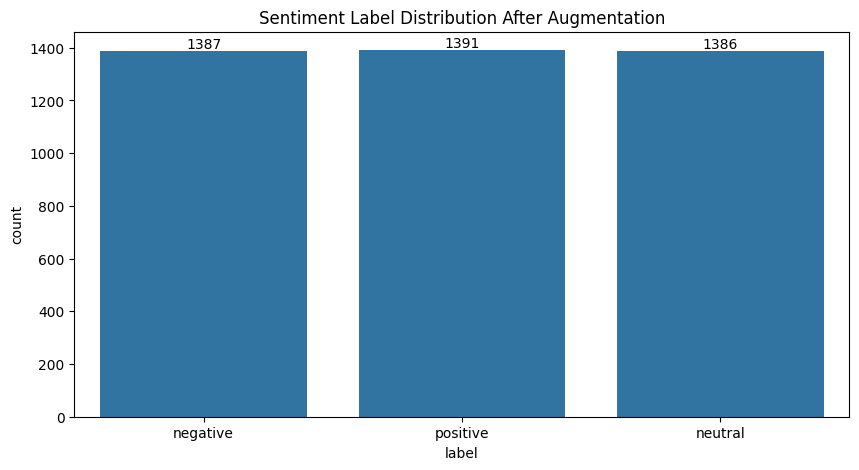

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=data_no_duplicates, x='label', ax=ax)
ax.bar_label(ax.containers[0])

ax.set_title('Sentiment Label Distribution After Augmentation')
plt.show()


## **Text Cleaning**

**1.Lowercase**

In [79]:
# Lowering text
def to_lowercase(text):
    return text.lower()

#Example
sample_text = "THE BANK IS GOING INTO LOST!"
lowercased_text = to_lowercase(sample_text)

print("Original Text: ", sample_text)
print("Lowercased Text: ", lowercased_text)


Original Text:  THE BANK IS GOING INTO LOST!
Lowercased Text:  the bank is going into lost!


**2. Contractions**

In [80]:
# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text) #(e.g., "don’t" → "do not")

# Example
sample_text = "She’s gone already? I can’t believe she didn’t say goodbye!"
expanded_text = expand_contractions(sample_text)

print("Original Text:", sample_text)
print("Expanded Text:", expanded_text)

Original Text: She’s gone already? I can’t believe she didn’t say goodbye!
Expanded Text: She is gone already? I cannot believe she did not say goodbye!


**3. Removing URLs**

In [81]:
# Function to remove URLs from text
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text)

# Example
sample_text = "To connect with me, visit my Insta at https://www.instagram.com/nn.neha or my Facebook at https://www.facebook.com/NehaShrestha."
cleaned_text = remove_urls(sample_text)

print("Original Text:", sample_text)
print("Text without URLs:", cleaned_text)

Original Text: To connect with me, visit my Insta at https://www.instagram.com/nn.neha or my Facebook at https://www.facebook.com/NehaShrestha.
Text without URLs: To connect with me, visit my Insta at  or my Facebook at 


**4. Removing Mentions**

In [82]:
# Function to remove @mentions from text
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

# Example
sample_text = "Big thanks to @nehashrestha and @laxmishrestha for the insights!"
cleaned_text = remove_mentions(sample_text)

print("Original Text:", sample_text)
print("Text without Mentions:", cleaned_text)

Original Text: Big thanks to @nehashrestha and @laxmishrestha for the insights!
Text without Mentions: Big thanks to  and  for the insights!


**5. Removing Hashtags**

In [83]:
# Function to remove hashtags
def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)

# Example
sample_text = "I love Artificial Intelligence and Machine Learning! #AI #ML #AIandML"
cleaned_text = remove_hashtags(sample_text)

print("Original Text:", sample_text)
print("Cleaned Text: ", cleaned_text)

Original Text: I love Artificial Intelligence and Machine Learning! #AI #ML #AIandML
Cleaned Text:  I love Artificial Intelligence and Machine Learning!   


**6. Removing Emojis**

In [84]:
# Remove emojis
def remove_emojis(text):
 # Regular expression pattern to match emojis
  emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # Emoticons
    u"\U0001F300-\U0001F5FF" # Symbols & Pictographs
    u"\U0001F680-\U0001F6FF" # Transport & Map Symbols
    u"\U0001F1E0-\U0001F1FF" # Flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
 # Using re.sub() to replace matched emojis with an empty string, effectively removing them from the text
  return emoji_pattern.sub(r' ', text)

# Example
sample_text = "I love programming! 😊🚀 #coding #python"
cleaned_text = remove_emojis(sample_text)

print("Original Text:", sample_text)
print("Cleaned Text: ", cleaned_text)

Original Text: I love programming! 😊🚀 #coding #python
Cleaned Text:  I love programming!   #coding #python


**7. Removing Special Characters and Numbers**

In [85]:
# Function to remove special characters from text
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Example u
sample_text = "Hello, World! This is a test... with special characters: @#&$"
cleaned_text = remove_special_characters(sample_text)

print("Original Text:", sample_text)
print("Cleaned Text: ", cleaned_text)

Original Text: Hello, World! This is a test... with special characters: @#&$
Cleaned Text:  Hello World This is a test with special characters 


**8. Text Tokenization**

In [86]:
# Function to tokenize the input text
def tokenize_text(text):
    return word_tokenize(text)

# Example
sample_text = "The final year is complex yet its the last year of bachelors."
tokens = tokenize_text(sample_text)
print("Tokens:", tokens)

Tokens: ['The', 'final', 'year', 'is', 'complex', 'yet', 'its', 'the', 'last', 'year', 'of', 'bachelors', '.']


**9. Lemmatization**

In [87]:
# Initialize the lemmatizer
lem = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenizing the input text into words, lemmatizing each word as a verb, and joining them back into a single string
    lemmatized_text = " ".join([lem.lemmatize(w, pos="v") for w in text.split()])
    return lemmatized_text

# Example
example_text = "I am running and jumping over the hurdles"
lemmatized_sentence = lemmatize_text(example_text)

print("Original sentence:", example_text)
print("Lemmatized sentence:", lemmatized_sentence)

Original sentence: I am running and jumping over the hurdles
Lemmatized sentence: I be run and jump over the hurdle


**10. Removing Stopwords**

In [88]:
# Creating a set of English stopwords
STOPWORDS = set(stopwords.words('english'))
print(list(STOPWORDS))

["she'll", 'up', 'himself', 'any', "isn't", 'because', 'y', 'which', 'other', 'does', 'those', 'just', 'only', "they've", 'this', 'how', 'off', "they'll", 'about', "you're", "i've", 'from', 'aren', 'then', 'hers', "you've", 'same', 'yourselves', 'won', "you'll", 'were', "i'd", 'shan', 'both', 'don', 'mustn', "shan't", "she's", 'some', 'who', 'again', 'him', 'with', "weren't", 'we', 'myself', 'wouldn', 'd', 'few', 'you', "aren't", 'should', 'too', 'are', 'been', "that'll", 'll', 'them', 'weren', 'when', 'yours', 're', 'haven', 'after', 'her', 'these', "wasn't", 'by', 'nor', 'whom', "he's", 'have', 'under', 'not', 've', 'there', 'its', 'he', 'of', "she'd", 'shouldn', 'at', 'ours', 'more', 'for', 'will', 'here', 'ourselves', "mightn't", 'in', 'why', 'isn', 'hadn', 'ma', 'o', 'once', 'be', 'hasn', 'own', 'an', 'below', 'i', 'until', 'his', 'do', 'had', 'was', 'against', 'didn', 'no', 'down', "we'll", 'theirs', "don't", "couldn't", 'my', 'if', "we're", 'can', 'now', 'out', 'or', 'being', "d

In [89]:
CLEANED_STOPWORDS = [] # Initializing empty list

# Iterating over each word in set of stopwords
for word in list(STOPWORDS):
  cleaned_word = word.replace("'", "")
  CLEANED_STOPWORDS.append(cleaned_word)
print(CLEANED_STOPWORDS)

['shell', 'up', 'himself', 'any', 'isnt', 'because', 'y', 'which', 'other', 'does', 'those', 'just', 'only', 'theyve', 'this', 'how', 'off', 'theyll', 'about', 'youre', 'ive', 'from', 'aren', 'then', 'hers', 'youve', 'same', 'yourselves', 'won', 'youll', 'were', 'id', 'shan', 'both', 'don', 'mustn', 'shant', 'shes', 'some', 'who', 'again', 'him', 'with', 'werent', 'we', 'myself', 'wouldn', 'd', 'few', 'you', 'arent', 'should', 'too', 'are', 'been', 'thatll', 'll', 'them', 'weren', 'when', 'yours', 're', 'haven', 'after', 'her', 'these', 'wasnt', 'by', 'nor', 'whom', 'hes', 'have', 'under', 'not', 've', 'there', 'its', 'he', 'of', 'shed', 'shouldn', 'at', 'ours', 'more', 'for', 'will', 'here', 'ourselves', 'mightnt', 'in', 'why', 'isn', 'hadn', 'ma', 'o', 'once', 'be', 'hasn', 'own', 'an', 'below', 'i', 'until', 'his', 'do', 'had', 'was', 'against', 'didn', 'no', 'down', 'well', 'theirs', 'dont', 'couldnt', 'my', 'if', 'were', 'can', 'now', 'out', 'or', 'being', 'didnt', 'ill', 'such', 

In [90]:
# Function to remove stopwords
def remove_stopwords(text):

  # Splitting input text into words, removing stopwords, and joining remaining words back into a single string
  stopwords_removed_text = " ".join([word for word in text.split() if word not in CLEANED_STOPWORDS])
  return stopwords_removed_text

example_text = "this is an example sentence with some stopword that we want to remove."
normalized_text = remove_stopwords(example_text)
print("Original sentence:", example_text)
print("Stopwords removed sentence:", normalized_text)

Original sentence: this is an example sentence with some stopword that we want to remove.
Stopwords removed sentence: example sentence stopword want remove.


### **Text Cleaning Pipeline**

In [91]:
# Defining the text cleaning pipeline
def clean_text_pipeline(text):
    text = expand_contractions(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = remove_emojis(text)
    text = remove_special_characters(text)
    text = lemmatize_text(text)
    text = remove_stopwords(text)
    text = to_lowercase(text)
    return text

# Defining path for cleaned data file
CLEANED_DATA_PATH = '/content/drive/MyDrive/2025_NehaShrestha/Assignment2/3. Financial Phrase Dataset/Cleaned_Data.csv'

data['cleaned_text'] = data['text'].apply(clean_text_pipeline)

print("\nOriginal vs Cleaned Text Examples:")
for i in range(3):
    print(f"Original: {data['text'].iloc[i]}")
    print(f"Cleaned: {data['cleaned_text'].iloc[i]}")
    print()


Original vs Cleaned Text Examples:
Original: Operating loss totalled EUR 4.0 mn , compared to a profit of EUR 8.6 mn in the second quarter of 2008 .
Cleaned: operating loss total eur mn compare profit eur mn second quarter

Original: HELSINKI AFX - KCI Konecranes said it has won an order for four hot metal ladle cranes from Indian steel producer Bhushan Steel and Strips Ltd. .
Cleaned: helsinki afx kci konecranes say win order four hot metal ladle crane indian steel producer bhushan steel strips ltd

Original: coalesced operating profit from continuing surgical operation decreased by 62.3 % to EUR 51.2 mn from EUR 135.7 mn in 2007 .
Cleaned: coalesce operate profit continue surgical operation decrease eur mn eur mn



### **Word Cloud**

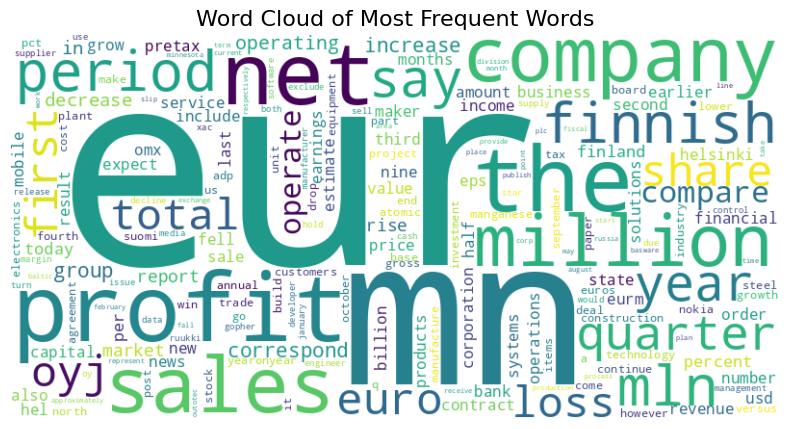

In [92]:
# Display most frequent words
cnt = Counter()
for text in data["cleaned_text"].dropna().values:
    for word in text.split():
        cnt[word] += 1

# Converting Counter to DataFrame
word_count_df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
word_count_df.reset_index(inplace=True)
word_count_df.columns = ['word', 'count']

# Displaying most frequent words (count >= threshold)
threshold = 8
word_count_df_filtered = word_count_df[word_count_df['count'] >= threshold]

# Converting to dictionary
word_counts_filtered = dict(zip(word_count_df_filtered['word'], word_count_df_filtered['count']))

# Generating and displaying word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Words", fontsize=16)
plt.show()


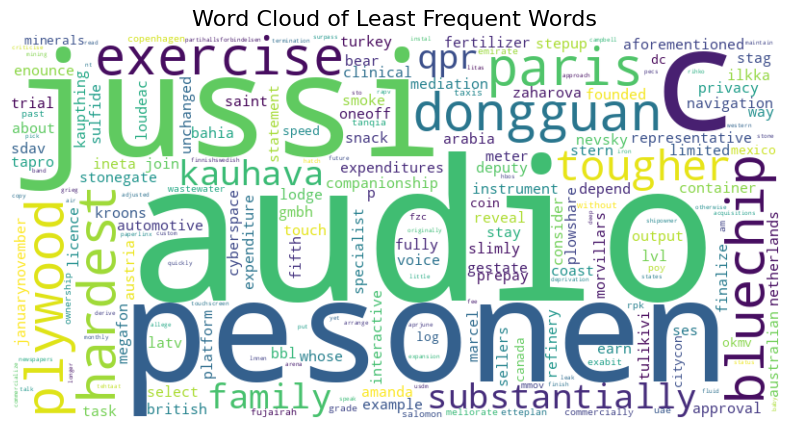

In [93]:
# Display least frequent words (count < threshold)
threshold = 5
word_count_df_filtered = word_count_df[word_count_df['count'] < threshold]

# Converting to dictionary
word_counts_filtered = dict(zip(word_count_df_filtered['word'], word_count_df_filtered['count']))

# Generating and displaying word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Least Frequent Words", fontsize=16)
plt.show()


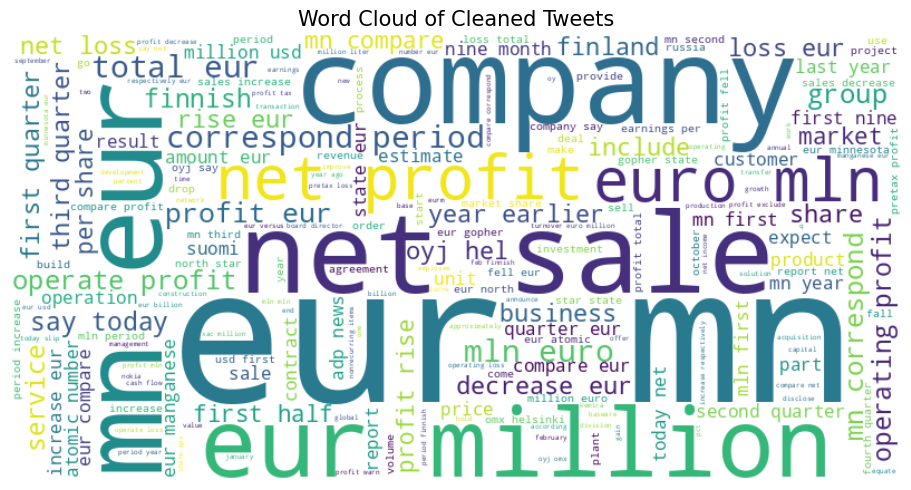

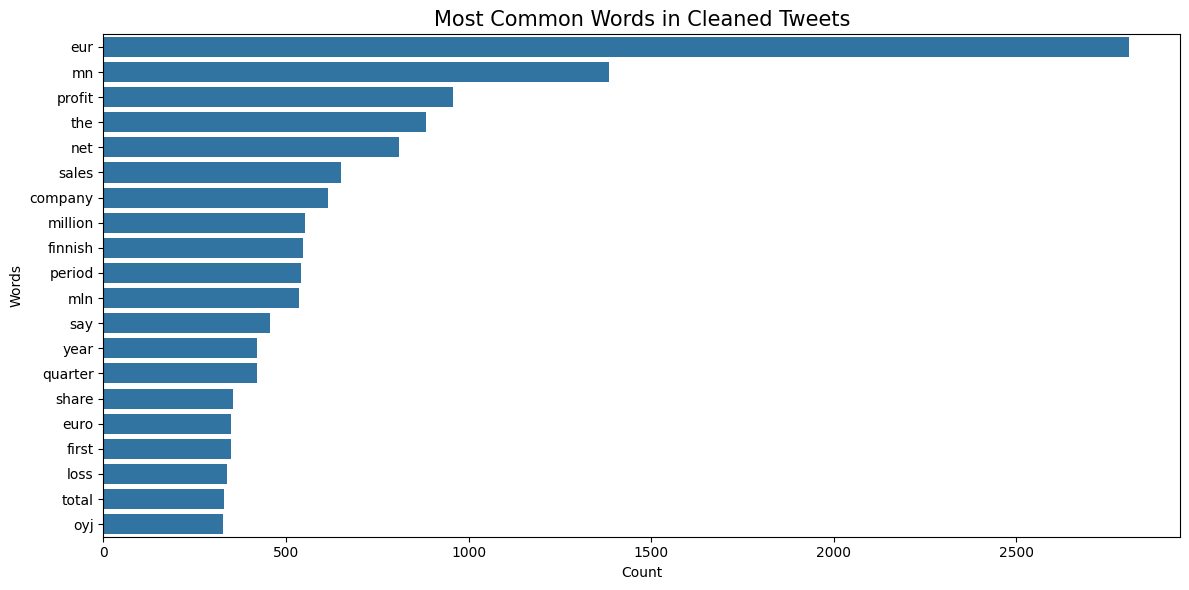

In [94]:
# Visualization for cleaned data
def plot_word_cloud(text_series, title):
    all_text = ' '.join(text_series.tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()

def plot_most_common_words(text_series, title, n=20):
    all_words = ' '.join(text_series.tolist()).split()
    word_count = Counter(all_words)
    most_common = word_count.most_common(n)

    words, counts = zip(*most_common)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title, fontsize=15)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

# Visualize cleaned data
plot_word_cloud(data['cleaned_text'], 'Word Cloud of Cleaned Tweets')
plot_most_common_words(data['cleaned_text'], 'Most Common Words in Cleaned Tweets')

### **Label Encoding for Sentiment Categories**

In [95]:
from sklearn.preprocessing import LabelEncoder
print("\n===== Encoding Text Labels in 'label' Column =====\n")
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

class_names = le.classes_
print(f"\nClass names found: {class_names}")
print(f"Number of unique classes: {len(class_names)}")


===== Encoding Text Labels in 'label' Column =====

{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

Class names found: ['negative' 'neutral' 'positive']
Number of unique classes: 3


### **Splitting Data into Train and Test Sets**

In [96]:
train_text, test_text, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['label'].astype('int32'),
    test_size=0.20, stratify=data['label'], random_state=42)

y_train = y_train.to_numpy(dtype='float32')
y_test  = y_test.to_numpy(dtype='float32')

print(f"Training set size: {train_text.shape[0]}")
print(f"Testing set size: {test_text.shape[0]}")

Training set size: 3338
Testing set size: 835


### **Tokenization**

In [97]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 5115


### **Text Sequence Padding**

95th percentile sequence length: 23


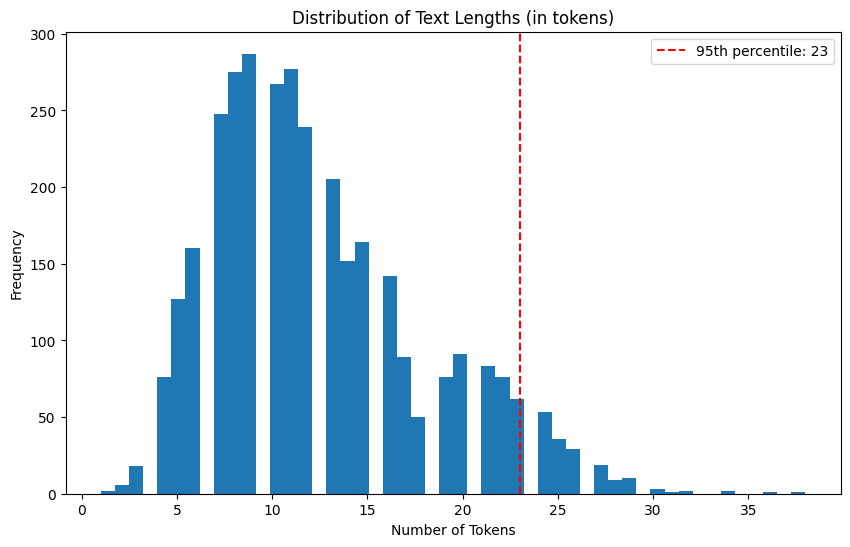

In [98]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_text)
X_test_seq = tokenizer.texts_to_sequences(test_text)

# Calculate the 95th percentile of sequence lengths
seq_lengths = [len(seq) for seq in X_train_seq]
max_length = int(np.percentile(seq_lengths, 95))
print(f"95th percentile sequence length: {max_length}")

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Plot sequence length distribution
plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50)
plt.axvline(x=max_length, color='r', linestyle='--', label=f'95th percentile: {max_length}')
plt.title('Distribution of Text Lengths (in tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### **Model Training History and Evaluation Metrics**

In [107]:
# Helpers: training-history plots & metrics

import itertools

def plot_history(histories, metric='accuracy'):
    """
    Plot loss and a chosen metric for any number of models.
    histories: list of tuples (name, history_object)
    """
    plt.figure(figsize=(14,5))
    # Loss
    plt.subplot(1,2,1)
    for name, h in histories:
        plt.plot(h.history['loss'], label=f'{name}-train')
        plt.plot(h.history['val_loss'], ls='--', label=f'{name}-val')
    plt.title('Loss');  plt.xlabel('epoch');  plt.legend()
    # Metric
    plt.subplot(1,2,2)
    for name, h in histories:
        plt.plot(h.history[metric], label=f'{name}-train')
        plt.plot(h.history[f'val_{metric}'], ls='--', label=f'{name}-val')
    plt.title(metric.capitalize());  plt.xlabel('epoch');  plt.legend()
    plt.show()


def evaluate_model(model, X, y_true, label_encoder, title='Model'):
    """Return y_pred and print accuracy, confusion-matrix & report."""
    y_pred_prob = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    acc = accuracy_score(y_true, y_pred)
    print(f'\n📝 {title} - Test accuracy: {acc:.4f}\n')

    # Confusion matrix
    class_names = [str(cls) for cls in label_encoder.classes_]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

    return y_pred

### **Building Deep Learning Models (RNN, LSTM, LSTM + GloVE)**

In [108]:
# Number of target classes & embedding size for trainable layers
le = LabelEncoder()
le.fit(y_train)

num_classes = len(le.classes_)
embed_dims_tr = 128
recurrent_units = 64

def build_rnn():
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embed_dims_tr,
                  input_length=max_length),
        SimpleRNN(recurrent_units),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


def build_lstm():
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embed_dims_tr,
                  input_length=max_length),
        LSTM(recurrent_units),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


def build_lstm_glove(glove_dim=100):
    """
    LSTM with pre-trained GloVe vectors (no gensim needed).
    Downloads glove.6B if absent and uses the txt inside
    /root/.keras/datasets/glove.6B/ .
    """
    import zipfile, pathlib, os, numpy as np, tensorflow as tf

    # 1) download (or locate) zip and ensure it's extracted
    zip_path = tf.keras.utils.get_file(
        'glove.6B.zip',
        origin='http://nlp.stanford.edu/data/glove.6B.zip',
        extract=True)
    glove_dir  = pathlib.Path(zip_path).with_suffix('')
    glove_file = glove_dir / f'glove.6B.{glove_dim}d.txt'

    if not glove_file.exists():
        raise FileNotFoundError(glove_file)

    # 2) build embeddings_index
    embeddings_index = {}
    with glove_file.open(encoding='utf-8') as f:
        for line in f:
            word, *vec = line.strip().split()
            embeddings_index[word] = np.asarray(vec, dtype='float32')

    # 3) embedding matrix aligned with tokenizer
    embedding_matrix = np.zeros((vocab_size, glove_dim))
    for word, i in tokenizer.word_index.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

    # 4) model
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=glove_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,   # safe to keep; warning is benign
                  trainable=False),
        LSTM(recurrent_units),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model




###**Training and Evaluating Three Deep Learning Models**

In [109]:
early = EarlyStopping(monitor='val_loss',
                      patience=3,
                      restore_best_weights=True)

BATCH = 16
EPOCH = 40
VALSPLIT = 0.1     # keep 10 % of training data for validation


#Model 1: Simple RNN
rnn_model = build_rnn()
hist_rnn  = rnn_model.fit(
    X_train_pad, y_train,
    epochs=EPOCH, batch_size=BATCH,
    validation_split=VALSPLIT,
    callbacks=[early], verbose=2)

#Model 2: LSTM (trainable emb)
lstm_model = build_lstm()
hist_lstm  = lstm_model.fit(
    X_train_pad, y_train,
    epochs=EPOCH, batch_size=BATCH,
    validation_split=VALSPLIT,
    callbacks=[early], verbose=2)

#Model 3: LSTM + GloVe (pre-trained)
lstm_glove_model = build_lstm_glove(glove_dim=100)
hist_glove = lstm_glove_model.fit(
    X_train_pad, y_train,
    epochs=EPOCH, batch_size=BATCH,
    validation_split=VALSPLIT,
    callbacks=[early], verbose=2)


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 - 6s - 34ms/step - accuracy: 0.6764 - loss: 0.7220 - val_accuracy: 0.8413 - val_loss: 0.4183
Epoch 2/40
188/188 - 2s - 12ms/step - accuracy: 0.9214 - loss: 0.2200 - val_accuracy: 0.8443 - val_loss: 0.3461
Epoch 3/40
188/188 - 2s - 11ms/step - accuracy: 0.9677 - loss: 0.0991 - val_accuracy: 0.8623 - val_loss: 0.3516
Epoch 4/40
188/188 - 2s - 11ms/step - accuracy: 0.9784 - loss: 0.0672 - val_accuracy: 0.8593 - val_loss: 0.3857
Epoch 5/40
188/188 - 2s - 11ms/step - accuracy: 0.9840 - loss: 0.0513 - val_accuracy: 0.8533 - val_loss: 0.3987
Epoch 1/40
188/188 - 8s - 41ms/step - accuracy: 0.5666 - loss: 0.7956 - val_accuracy: 0.5868 - val_loss: 0.6707
Epoch 2/40
188/188 - 3s - 17ms/step - accuracy: 0.7187 - loss: 0.5319 - val_accuracy: 0.7395 - val_loss: 0.5984
Epoch 3/40
188/188 - 3s - 17ms/step - accuracy: 0.9031 - loss: 0.2711 - val_accuracy: 0.8263 - val_loss: 0.5524
Epoch 4/40
188/188 - 5s - 26ms/step - accuracy: 0.9507 - loss: 0.1550 - val_accuracy: 0.8713 - val_loss: 0.3560
Epo

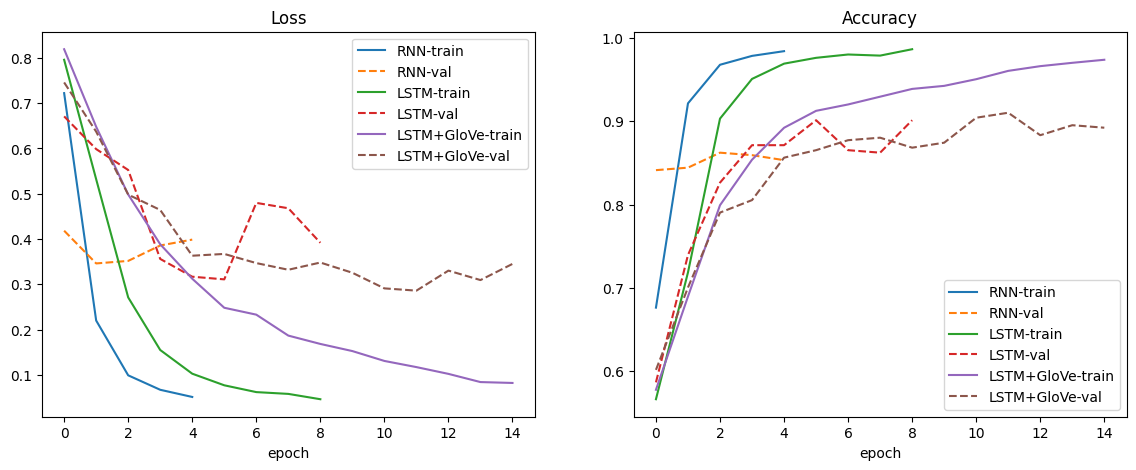

In [110]:
plot_history([('RNN',   hist_rnn),
              ('LSTM',  hist_lstm),
              ('LSTM+GloVe', hist_glove)])

### **Final Evaluation on the Test Set**

In this context, the class labels are encoded as follows:

| Sentiment   |    Label |
| ----------- | -------: |
| Negative    |        0 |
| Neutral     |        1 |
| Positive    |        2 |


============== FINAL TEST METRICS ==============

📝 RNN - Test accuracy: 0.8778



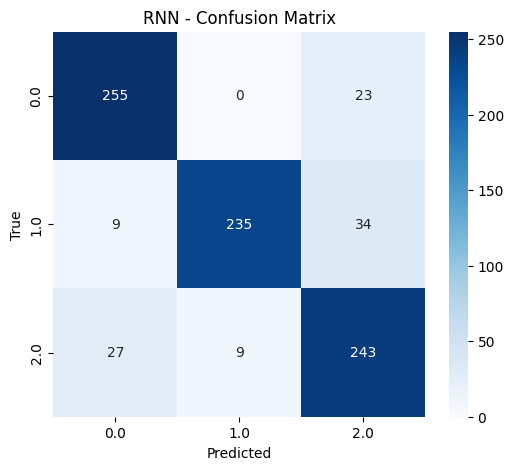

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       278
         1.0       0.96      0.85      0.90       278
         2.0       0.81      0.87      0.84       279

    accuracy                           0.88       835
   macro avg       0.88      0.88      0.88       835
weighted avg       0.88      0.88      0.88       835


📝 LSTM - Test accuracy: 0.8922



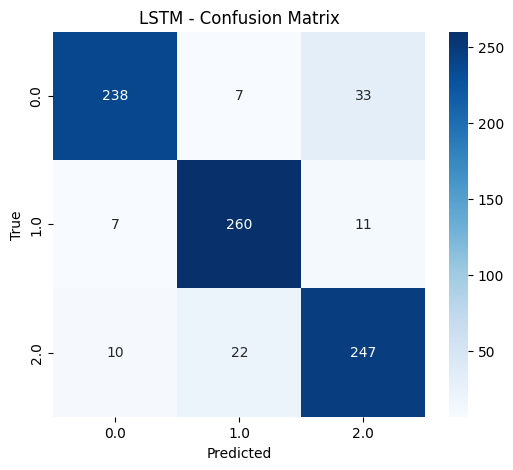

              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89       278
         1.0       0.90      0.94      0.92       278
         2.0       0.85      0.89      0.87       279

    accuracy                           0.89       835
   macro avg       0.89      0.89      0.89       835
weighted avg       0.89      0.89      0.89       835


📝 LSTM + GloVe - Test accuracy: 0.9090



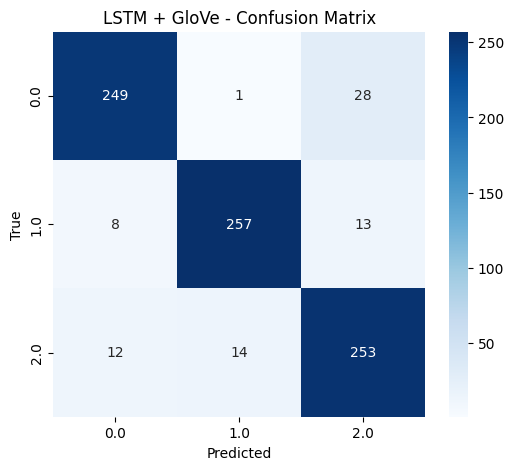

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91       278
         1.0       0.94      0.92      0.93       278
         2.0       0.86      0.91      0.88       279

    accuracy                           0.91       835
   macro avg       0.91      0.91      0.91       835
weighted avg       0.91      0.91      0.91       835



,Model,Test_Acc.
2,LSTM+GloVe,0.9090
1,LSTM,0.8922
0,RNN,0.8778


In [111]:
print('============== FINAL TEST METRICS ==============')
pred_rnn   = evaluate_model(rnn_model,         X_test_pad, y_test, le, 'RNN')
pred_lstm  = evaluate_model(lstm_model,        X_test_pad, y_test, le, 'LSTM')
pred_glove = evaluate_model(lstm_glove_model,  X_test_pad, y_test, le, 'LSTM + GloVe')

# Simple summary table
results = pd.DataFrame({
    'Model'      : ['RNN','LSTM','LSTM+GloVe'],
    'Test_Acc.'  : [accuracy_score(y_test, p)
                    for p in [pred_rnn, pred_lstm, pred_glove]]
})
display(results.sort_values('Test_Acc.', ascending=False).style.format({'Test_Acc.':'{:.4f}'}))


### **GUI for Real Time Prediction (Gradio)**

In [112]:
# Save tokenizer to a file
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [113]:
print(os.path.exists("tokenizer.pkl"))  # Should print: True

True


In [114]:
# Load tokenizer and model
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

model = lstm_glove_model
maxlen = 18

# Preprocess the input text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def predict_class(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=maxlen, padding='post')
    probs = model.predict(pad, verbose=0)[0]
    i    = int(np.argmax(probs))
    label, conf = le.inverse_transform([i])[0], probs[i]
    return f"**{label}**  (confidence {conf:.1%})"

In [115]:
interface = gr.Interface(
    fn=predict_class,
    inputs=gr.Textbox(lines=2, placeholder="Enter your text:"),
    outputs="text",
    title="Financial Phrase Sentiment Classifier",
    description="Enter a phrase and get an instant sentiment prediction.",
    examples=[
        ["Profit growth exceeds expectations"],
        ["Strong consumer demand drives sales"],
        ["Company is closed today"],
        ["Company expands into new markets"],
        ["Market remains neutral ahead of Fed meeting"]
    ],
    theme="default",
    live=False
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7a3c1b5c4020f10d55.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
